# EfficientDet 1

In [5]:
import os
import sys
from nfl.settings import Settings
settings = Settings(path_project="/Users/thimmzwiener/dev/nfl-challenge/")



The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
from efficientdet.dataset import CocoDataset, Resizer, Normalizer, Augmenter, collater
from torchvision import transforms
params = settings.nn_parameters
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
from torch.utils.data import DataLoader


In [7]:
from nfl.models.efficientdet.lib.infer_detector import Infer
gtf_infer = Infer()
gtf_infer.Model(model_dir="../models/")

#extract class list from our annotations
import json
with open('../data/processed/annotations/instances_processed_images.json') as json_file:
    data = json.load(json_file)
class_list = []

for category in data['categories']:
    class_list.append(category['name'])

Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.
Loading model for CPU mode because CUDA is not available.


Done. (4.196s)


Empty DataFrame
Columns: [xmin, ymin, xmax, ymax]
Index: []

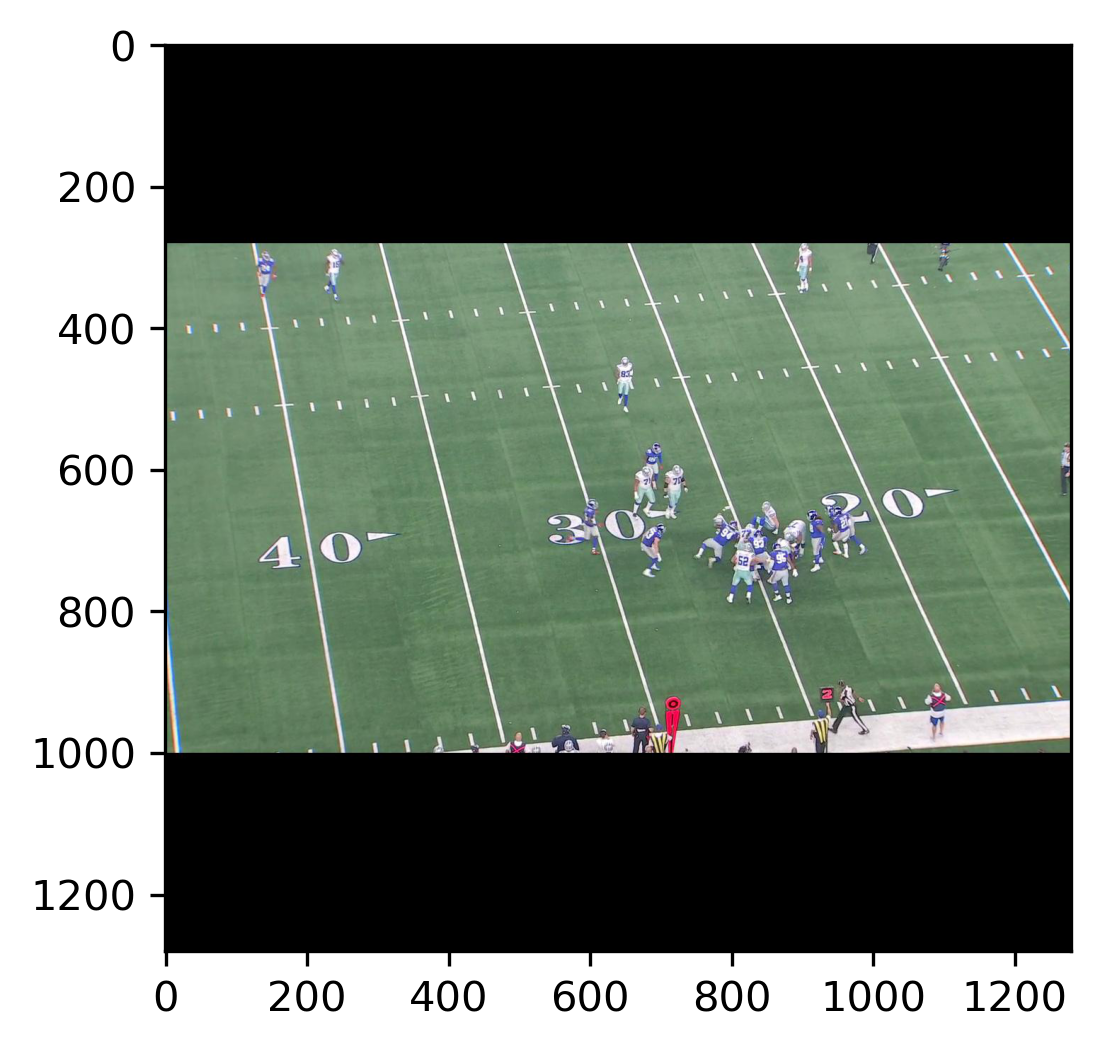

In [32]:
import random
from IPython.display import Image
import pandas as pd
from nfl.visualization.visualize import add_img_boxes
import cv2
import imageio
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 300


img_paths = list(Path("../data/processed/processed_images/").glob("*.jpg"))
img_path = str(random.choice(img_paths))
duration, prob, cl, bb = gtf_infer.Predict(img_path, class_list, vis_threshold=0.5)
bb = pd.DataFrame(bb.numpy(), columns=["xmin", "ymin", "xmax", "ymax"])


def add_img_boxes(image_path, boxes):
    # Set label colors for bounding boxes
    HELMET_COLOR = (255, 255, 255)    # Black
    image = imageio.imread(image_path)
    for j, box in boxes.iterrows():
        color = HELMET_COLOR 
        # Add a box around the helmet
        # Note that cv2.rectangle requires us to specify the top left pixel and the bottom right pixel
        cv2.rectangle(image, (box.xmin, box.ymin), (box.xmax, box.ymax), color, thickness=3)
        
    # Display the image with bounding boxes added
    return image
display(bb)
plt.imshow(add_img_boxes(img_path, bb))

# Efficientdet 2

In [15]:

import random
from matplotlib import pyplot as plt
# Author: Zylo117

"""
Simple Inference Script of EfficientDet-Pytorch
"""
import time
import torch
from torch.backends import cudnn
from matplotlib import colors

from backbone import EfficientDetBackbone
import cv2
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess, STANDARD_COLORS, standard_to_bgr, get_index_label, plot_one_box


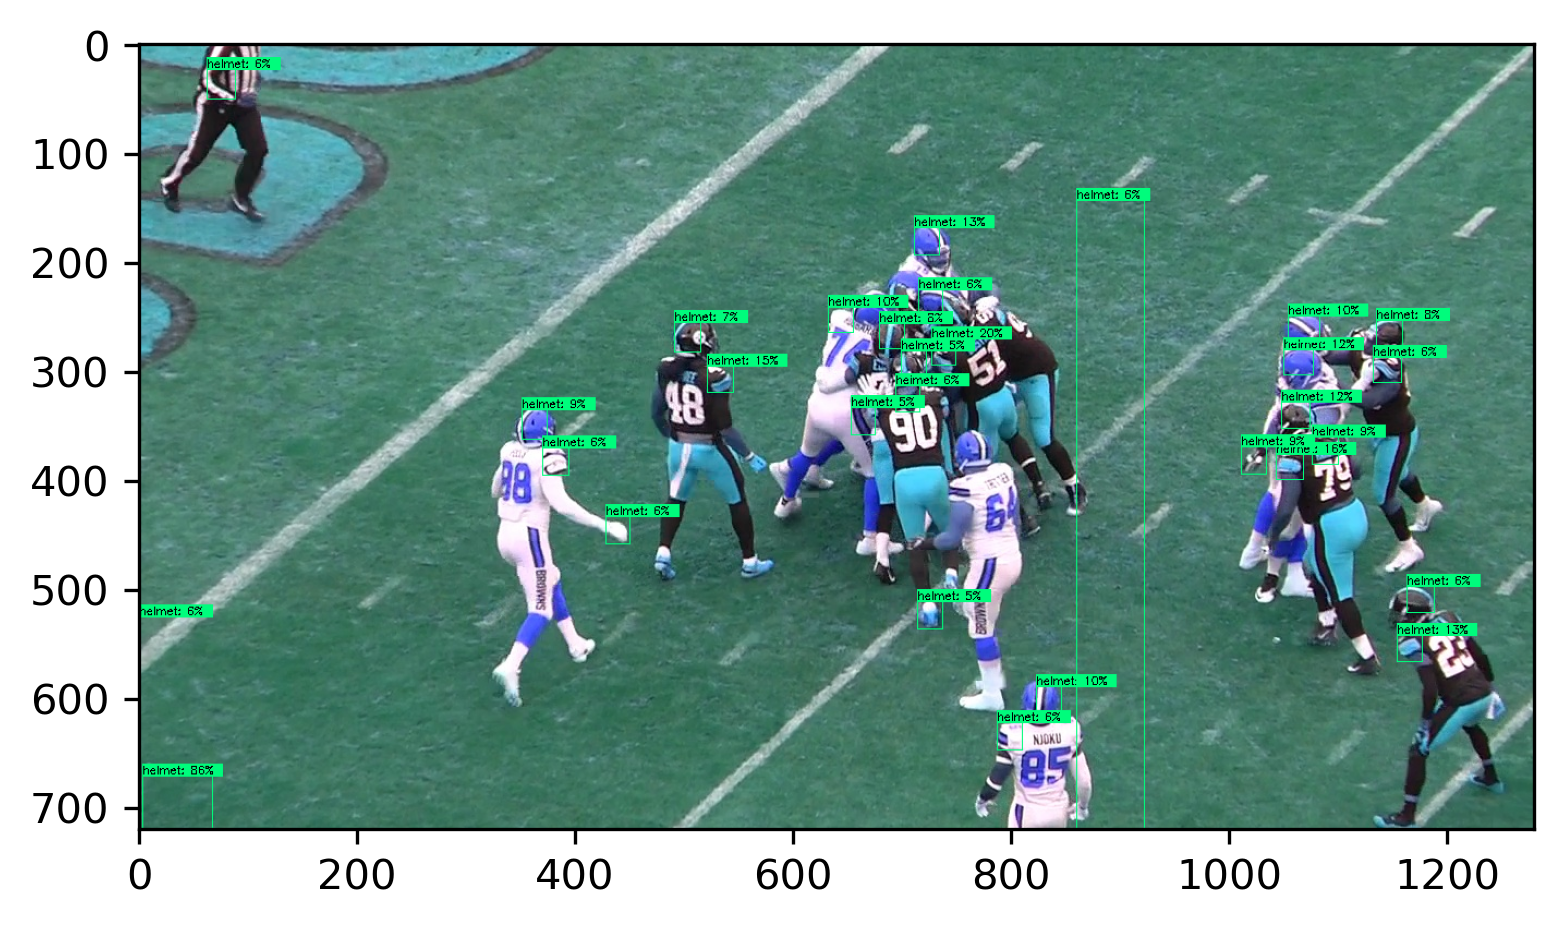

In [80]:

compound_coef = settings.nn_parameters.compound_coef
force_input_size = None  # set None to use default size
img_path = str(random.choice(list(settings.path_prepared_train_video_images.glob("*.jpg"))))

# replace this part with your project's anchor config
anchor_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]
anchor_scales = [2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

threshold = 0.05
iou_threshold = 0.05

use_cuda = False
use_float16 = False
cudnn.fastest = False
cudnn.benchmark = False

obj_list = settings.nn_parameters.obj_list


color_list = standard_to_bgr(STANDARD_COLORS)
# tf bilinear interpolation is different from any other's, just make do
input_sizes = [1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),
                             ratios=anchor_ratios, scales=anchor_scales)
model.load_state_dict(torch.load(f'../models/2020_11_30_efficientdet-d0_19_29320.pth', map_location="cpu"))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

def display_img(preds, imgs, imshow=True, imwrite=False):
    for i in range(len(imgs)):
        if len(preds[i]['rois']) == 0:
            continue

        for j in range(len(preds[i]['rois'])):
            x1, y1, x2, y2 = preds[i]['rois'][j].astype(np.int)
            obj = obj_list[preds[i]['class_ids'][j]]
            score = float(preds[i]['scores'][j])
            plot_one_box(imgs[i], [x1, y1, x2, y2], label=obj,score=score,color=color_list[get_index_label(obj, obj_list)])


        if imshow:
#             cv2.imshow('img', imgs[i])
            plt.figure(dpi=300)
            display(plt.imshow(imgs[i]))

        if imwrite:
            cv2.imwrite(f'test/img_inferred_d{compound_coef}_this_repo_{i}.jpg', imgs[i])


out = invert_affine(framed_metas, out)
display_img(out, ori_imgs, imshow=True, imwrite=True)
